# Import Libraries

In [22]:
#import libraries
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

import copy
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import requests

from PIL import Image
from io import BytesIO

# Fetching Data

In [23]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.CIFAR10(root='./data',
                                        train= True,
                                        download = True,
                                        transform=transforms.Compose([transforms.ToTensor()]))
val_data = torchvision.datasets.CIFAR10(root='./data',
                                        train= False,
                                        download = True,
                                        transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [24]:
size_batch = 50
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = size_batch)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size = size_batch)

# Create Model

In [25]:
def create_model():
    model = nn.Sequential(
        
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)       
    )
    
    return model

# Validate Model

In [26]:
def validate(model, data):
    total = 0
    correct = 0
    
    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        total += x.size(0)
        correct += torch.sum(pred == labels)
    
    return correct * 100. / total

In [27]:
def train_accuracy(model, data):
    total = 0
    correct = 0
    
    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        total += x.size(0)
        correct += torch.sum(pred == labels)
    
    return correct * 100. / total

# Training Function

In [28]:
def train(numb_epoch = 5, lr = 0.004):
    accuracies = []
    cnn = create_model()
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dataloader):
            
            optimizer.zero_grad()
            grad = cnn(images)
            loss = cec(grad, labels)
            loss.backward()
            optimizer.step()
        
        accuracy = float(validate(cnn, val_dataloader))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            
            print("Saving Best model with accuracy: ", accuracy)
            
        print("Epoch: ", epoch+1, "Val Accuracy:", accuracy, "%\n")
    plt.plot(accuracies)
    return best_model

# Training Model

Saving Best model with accuracy:  61.5099983215332
Epoch:  1 Val Accuracy: 61.5099983215332 %

Saving Best model with accuracy:  71.37999725341797
Epoch:  2 Val Accuracy: 71.37999725341797 %

Saving Best model with accuracy:  73.30000305175781
Epoch:  3 Val Accuracy: 73.30000305175781 %

Saving Best model with accuracy:  76.30000305175781
Epoch:  4 Val Accuracy: 76.30000305175781 %

Saving Best model with accuracy:  76.41000366210938
Epoch:  5 Val Accuracy: 76.41000366210938 %

Epoch:  6 Val Accuracy: 74.62999725341797 %

Saving Best model with accuracy:  76.55999755859375
Epoch:  7 Val Accuracy: 76.55999755859375 %

Saving Best model with accuracy:  77.58999633789062
Epoch:  8 Val Accuracy: 77.58999633789062 %

Epoch:  9 Val Accuracy: 76.87999725341797 %

Epoch:  10 Val Accuracy: 76.77999877929688 %



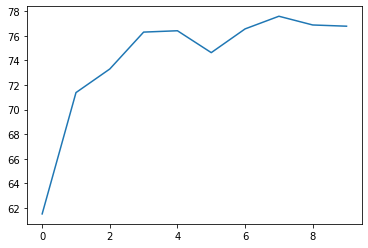

In [29]:
best_model = train(10)

# Prediction Function

In [30]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images,labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    
    return np.array(y_pred), np.array(y_true)

In [31]:
y_pred, y_true = predict_dl(best_model, val_dataloader)
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,816,15,36,22,22,6,3,13,44,23
1,5,933,1,3,1,3,2,0,8,44
2,66,8,610,98,81,43,47,31,8,8
3,15,12,40,692,33,104,40,37,10,17
4,18,2,48,99,709,25,21,59,11,8
5,6,3,25,210,31,650,15,48,6,6
6,6,13,25,103,29,17,787,5,8,7
7,11,3,13,48,26,40,2,845,4,8
8,43,32,7,17,3,0,7,3,872,16
9,24,82,4,16,2,5,1,7,14,845


# Custom Input Function

In [32]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def predict_custom(path, model):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert('RGB')
        img = img.resize((32,32))
        x = (255 - np.expand_dims(np.array(img), -1)) / 255
        t = torch.from_numpy(x.squeeze())
        plt.imshow(x.squeeze(-1))
        
    with torch.no_grad():
        x = t.numpy()
        pred = model(torch.unsqueeze(T(x), axis = 0).float())
        pred = F.softmax(pred, dim= -1).numpy()
        pred_idx = np.argmax(pred)
        print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")        
        return classes[pred_idx]

# Custom Input Predict

Predicted: 2, Prob: 99.91045594215393 %
bird


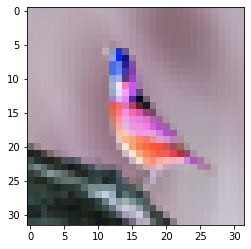

In [33]:
path = 'https://cdn.download.ams.birds.cornell.edu/api/v1/asset/202984001/1200'
pred = predict_custom(path,best_model)
print(pred)

Predicted: 0, Prob: 85.58186888694763 %
plane


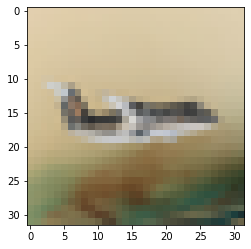

In [35]:
path = 'https://assets.bwbx.io/images/users/iqjWHBFdfxIU/ioY9jnR7w52Y/v0/1200x-1.jpg'
pred = predict_custom(path,best_model)
print(pred)